In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
import random
display(HTML("<style>.container { width:90% !important; }</style>"))

import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from functools import partial

import torch

from pyro.nn import AutoRegressiveNN, ConditionalAutoRegressiveNN

from pyro.distributions import constraints
from pyro.distributions.conditional import ConditionalTransformModule
from pyro.distributions.torch_transform import TransformModule
from pyro.distributions.util import copy_docs_from
from pyro.distributions.transforms import SplineCoupling
from pyro.distributions.transforms.spline import ConditionalSpline



import numpy as np
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
#from data_utils.data_loader import HDF5Dataset, MaxwellBatchLoader, MaxwellBatchLoaderFullyCond


#import ML_models.models as models
#import ML_models.functions as functions
import time
import h5py

from custom_pyro import ConditionalAffineCouplingTanH

from pyro.nn import ConditionalDenseNN, DenseNN, ConditionalAutoRegressiveNN
import pyro.distributions as dist
import pyro.distributions.transforms as T

from models.shower_flow import compile_HybridTanH_model, compile_HybridTanH_model_CaloC


device = torch.device('cuda:0')

/tmp/ipykernel_123278/1380459013.py:4: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
# num_inputs: visible_energy 1 + num_points (total) 1 + e_per_layer (normalized [0, 1]) 45, num_point_per_layer (normalized [0, 1]) 45 = 92
model, distribution = compile_HybridTanH_model_CaloC(num_blocks = 10, 
                                           num_inputs=92, ### when 'condioning' on additional Esum, Nhits etc add them on as inputs rather than 
                                           num_cond_inputs=1, device=device)  # num_cond_inputs

In [3]:
default_params = {
    "batch_size" : 512,
    "epochs" : 500, # 138 epochs with lr 5e-5, then to 300 epochs with lr 1e-5 and to 500 with 5e-6
    "shuffle" : True,
}

In [4]:
kwargs = {}
params = {}
for param in default_params.keys():

    if param in kwargs.keys():
        params[param] = kwargs[param]
    else:
        params[param] = default_params[param]

In [13]:
path = '/beegfs/desy/user/akorol/data/calo-challange/dataset_3_xyz_tarin.hdf5'
energy = h5py.File(path, 'r')['energy'][:]
events = h5py.File(path, 'r')['events'][-93060:]

num_points = (events[:][:, -1] > 0).sum(axis=1)
visible_energy = (events[:][:, -1]).sum(axis=1)

In [15]:
events.shape

(93060, 4, 22000)

In [5]:
# path =  '/beegfs/desy/user/valentel/CaloTransfer/data/calo-challenge/dataset_3_xyz_tarin.hdf5'
path = '/beegfs/desy/user/valentel/CaloTransfer/data/calo-challenge/dataset_3_3_10-90GeV.hdf5'

# chosen_size = 99000
# percentage = 0.5

# size = int ( chosen_size * percentage)
# idx = np.random.choice(np.arange((1e5 - chosen_size), 1e5), size=size, replace=False)
# # idx = np.sort(idx).astype(int)


energy = h5py.File(path, 'r')['incident_energies'][ : ]
events = h5py.File(path, 'r')['showers'][ : ]

# num_points = (events[:][:, -1] > 0).sum(axis=1)
# visible_energy = (events[:][:, -1]).sum(axis=1)


# if shape is ( n , 40500)
# Calculate the number of non-zero data points per event
num_points = (events > 0).sum(axis=1)

# Calculate the total sum of data points per event
visible_energy = events.sum(axis=1)

print('Number of non-zero points per event:', num_points)
print('Total visible energy per event:', visible_energy)


Number of non-zero points per event: [1333 1657 3975 ... 4143 3390 3347]
Total visible energy per event: [11597.24899718 17199.13436812 61124.89407975 ... 54878.24215312
 49910.81497026 51369.13338921]


In [6]:
# for validation
# visible_energy_true = (events[:][:, -1]).sum(axis=1)
# num_points_true = (events[:][:, -1] > 0).sum(axis=1)

# if shape is ( n , 40500 )
visible_energy_true = ( events > 0 ).sum(axis=1)
num_points_true = (events > 0).sum(axis=1)

energy_true = h5py.File(path, 'r')['incident_energies'][:]

min and max points:  330 4961


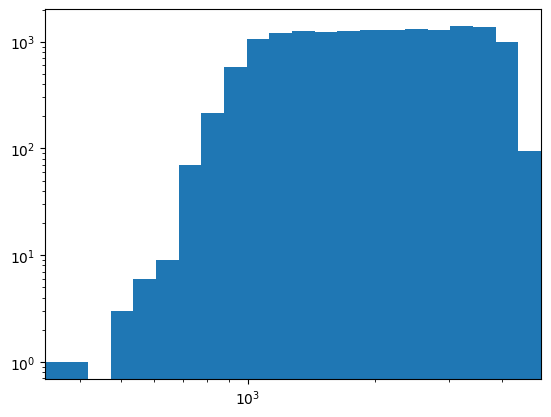

In [7]:
plt.hist(num_points, bins=np.logspace(np.log(1e-7), np.log(num_points.max()), 200, base=np.e),)
plt.xscale('log')
plt.yscale('log')
plt.xlim(xmin = num_points.min(), xmax = num_points.max())
print('min and max points: ',num_points.min(), num_points.max())
plt.show()

In [8]:
import os 
e_per_layer_path = './utils/per_layer/evaluation_10-90GeV_clusters_per_layer.npy'
clusters_per_layer_path = './utils/per_layer/evaluation_10_90GeV_e_per_layer.npy'


if not os.path.exists(e_per_layer_path) and not os.path.exists(clusters_per_layer_path):
    # takes some time to run this, calculate it onces and then save as numpy
    clusters_per_layer = []
    for i in tqdm(range(45)):
        clusters_per_layer.append( ((events[:, 2, :] < i+1) & (events[:, 2, :] > i)).sum(axis=1) )

    clusters_per_layer = np.vstack(clusters_per_layer)
    clusters_per_layer = np.moveaxis(clusters_per_layer, 0, -1)

    e_per_layer = []
    for i in tqdm(range(45)):
        layer_mask = (events[:, 2, :] < i+1) & (events[:, 2, :] > i)
        e_per_layer.append( (events[:, -1, :] * layer_mask).sum(axis=1) )
        
    e_per_layer = np.vstack(e_per_layer)
    e_per_layer = np.moveaxis(e_per_layer, 0, -1)

    # save 
    np.save(e_per_layer_path, e_per_layer)
    np.save(clusters_per_layer_path, clusters_per_layer)

In [9]:
e_per_layer_path = './utils/per_layer/evaluation_10-90GeV_clusters_per_layer.npy'
clusters_per_layer_path = './utils/per_layer/evaluation_10_90GeV_e_per_layer.npy'


# Only perform calculations if the files do not already exist
if not os.path.exists(e_per_layer_path) and not os.path.exists(clusters_per_layer_path):
    # Assume there are 45 "layers", each containing an equal portion of the 40500 features
    num_layers = 45
    layer_width = 40500 // num_layers  # Calculate the number of features per layer
    
    # Initialize lists to store results for each layer
    clusters_per_layer = []
    e_per_layer = []

    # Iterate over each layer and calculate the required metrics
    for i in tqdm(range(num_layers)):
        # Calculate the start and end indices for each layer
        start_idx = i * layer_width
        end_idx = start_idx + layer_width

        # Calculate the number of non-zero points in each layer
        layer_data = events[:, start_idx:end_idx]
        clusters_per_layer.append(np.count_nonzero(layer_data, axis=1))

        # Calculate the sum of points in each layer
        e_per_layer.append(np.sum(layer_data, axis=1))

    # Convert results from lists to arrays and save them
    np.save(clusters_per_layer_path, np.array(clusters_per_layer).T)
    np.save(e_per_layer_path, np.array(e_per_layer).T)

In [10]:
# load precalculated
e_per_layer = np.load(e_per_layer_path)
clusters_per_layer = np.load(clusters_per_layer_path)
print('e per layer shape: ', e_per_layer.shape)
print('cluster per layer shape: ', clusters_per_layer.shape)

e per layer shape:  (15921, 45)
cluster per layer shape:  (15921, 45)


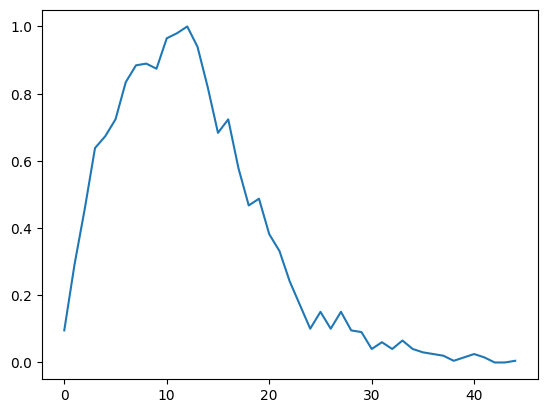

In [11]:
plt.plot(clusters_per_layer[300]/clusters_per_layer[300].max())
plt.show()

In [12]:
clusters_per_layer = clusters_per_layer / clusters_per_layer.max(axis=1).reshape(len(clusters_per_layer), 1)
e_per_layer = e_per_layer / e_per_layer.max(axis=1).reshape(len(e_per_layer), 1)

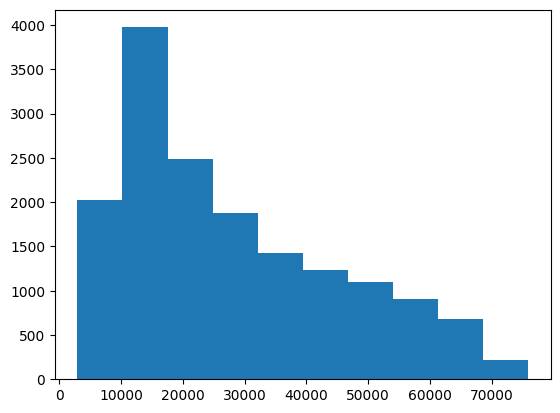

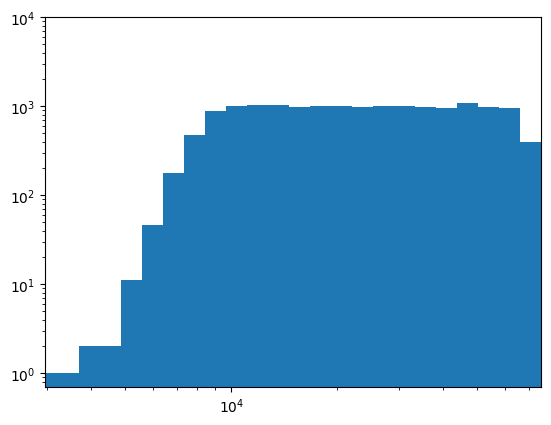

In [13]:
plt.hist(visible_energy)
plt.show()
plt.hist(visible_energy, bins=np.logspace(np.log(1e-7), np.log(visible_energy.max()), 200, base=np.e))
plt.xscale('log')
plt.yscale('log')
plt.xlim(xmin=visible_energy.min(), xmax=visible_energy.max() )
plt.ylim(ymax=1e4)


plt.show()

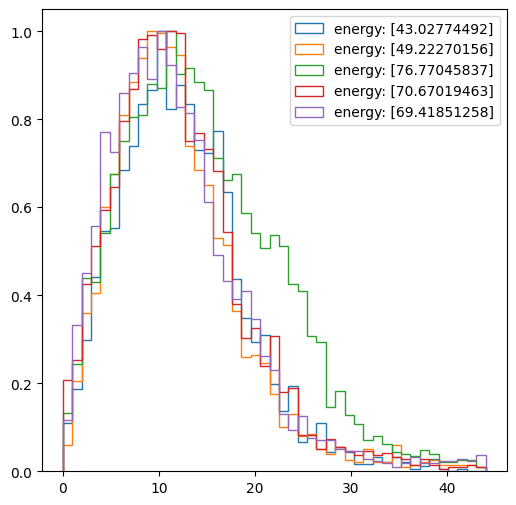

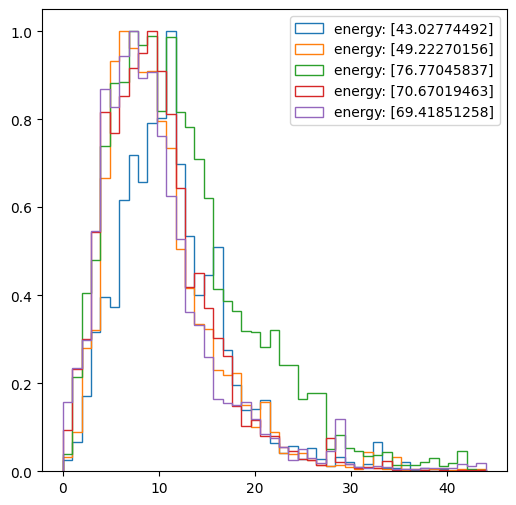

In [14]:
plt.figure(figsize=(6,6))
for i in range(len(clusters_per_layer)-5, len(clusters_per_layer)):
    plt.hist(np.arange(45), weights=clusters_per_layer[i, :], label=f'energy: {energy[i]}', histtype='step', bins=45)
plt.legend()
plt.show()

plt.figure(figsize=(6,6))
for i in range(len(e_per_layer)-5, len(e_per_layer)):
    plt.hist(np.arange(45), weights=e_per_layer[i, :], label=f'energy: {energy[i]}', histtype='step', bins=45)
plt.legend()
plt.show()

In [15]:
df = pd.DataFrame([])
df['energy'] = ( np.log(energy/energy.min()) / np.log(energy.max()/energy.min()) ).reshape(-1)
df['visible_energy'] = ( np.log(visible_energy/visible_energy.min()) / np.log(visible_energy.max()/visible_energy.min()) ).reshape(-1)
df['num_points'] = ( np.log((num_points+1)/num_points.min()) / np.log(num_points.max()/num_points.min()) ).reshape(-1)

df['clusters_per_layer'] = clusters_per_layer.tolist()
df['e_per_layer'] = e_per_layer.tolist()

df

,energy,visible_energy,num_points,clusters_per_layer,e_per_layer
0,0.264118,0.420897,0.515389,"[0.008403361344537815, 0.05042016806722689, 0....","[0.0036454274119931173, 0.01685144396373416, 0..."
1,0.455201,0.542385,0.595614,"[0.05426356589147287, 0.20155038759689922, 0.2...","[0.047218325174305534, 0.12304675836261526, 0...."
2,0.925181,0.933292,0.918336,"[0.15486725663716813, 0.24778761061946902, 0.3...","[0.07797454497333199, 0.3355939432056509, 0.16..."
3,0.701068,0.751043,0.747288,"[0.11173184357541899, 0.2569832402234637, 0.48...","[0.04269276493279787, 0.12435548900458769, 0.2..."
4,0.096989,0.350499,0.430211,"[0.07407407407407407, 0.07407407407407407, 0.4...","[0.043013930913128044, 0.010752550444638236, 0..."
...,...,...,...,...,...
15916,0.664094,0.720308,0.757043,"[0.11049723756906077, 0.1878453038674033, 0.29...","[0.026280688076925185, 0.06712512537376449, 0...."
15917,0.725328,0.797844,0.793018,"[0.06, 0.205, 0.36, 0.405, 0.6, 0.675, 0.81, 0...","[0.03257526624053497, 0.08938330658986482, 0.2..."
15918,0.927667,0.900060,0.933606,"[0.13333333333333333, 0.24444444444444444, 0.4...","[0.04026097498878561, 0.21446434759319902, 0.4..."
15919,0.889975,0.870811,0.859615,"[0.2081447963800905, 0.25339366515837103, 0.42...","[0.09442385273267442, 0.23167918786282252, 0.3..."


In [16]:
visible_energy.min() * (np.e ** (df.visible_energy.values * np.log(visible_energy.max() / visible_energy.min())))


array([11597.24899718, 17199.13436812, 61124.89407975, ...,
       54878.24215312, 49910.81497026, 51369.13338921])

In [17]:
visible_energy

array([11597.24899718, 17199.13436812, 61124.89407975, ...,
       54878.24215312, 49910.81497026, 51369.13338921])

In [18]:
num_points.min() * (np.e ** (df.num_points.values * np.log(num_points.max() / num_points.min()))) - 1

array([1333., 1657., 3975., ..., 4143., 3390., 3347.])

In [19]:
num_points

array([1333, 1657, 3975, ..., 4143, 3390, 3347])

In [20]:
dataset = torch.utils.data.TensorDataset(
    torch.tensor(df.energy.values), 
    torch.tensor(df.visible_energy.values),
    torch.tensor(df.num_points.values),
    torch.tensor(df.e_per_layer),
    torch.tensor(df.clusters_per_layer)
    )

In [21]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=params["batch_size"], shuffle=params["shuffle"], pin_memory=True)


In [22]:
batch = next(iter(train_loader))

In [23]:
# items in batch: (insident energy, visible_energy, num_points, e_per_layer, clusters_per_layer)
for item in batch:
    print(item.shape)

torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512, 45])
torch.Size([512, 45])


In [ ]:
import comet_ml
import logging
from configs import Configs

# Set the logging level for comet_ml
logging.getLogger("comet_ml").setLevel(logging.ERROR)

cfg = Configs()

with open('./utils/comet_api_key.txt', 'r') as file:
    key = file.read()

# Log in to Comet (replace 'your-api-key' and 'your-project-name' with your actual Comet API key and project name)
comet_logger = comet_ml.Experiment(
    api_key=key,
    project_name='showerflow',
    auto_metric_logging=False,
    workspace="lorenzovalente3",
)

lr = 1e-6

model.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

if cfg.uda:
    model, distribution = compile_HybridTanH_model(num_blocks=10, 
                                           num_inputs=65, ### when 'condioning' on additional Esum, Nhits etc add them on as inputs rather than 
                                           num_cond_inputs=1, device=device)  # num_cond_inputs
    path_showerflow = '/beegfs/desy/user/valentel/6_PointCloudDiffusion/shower_flow/220714_cog_e_layer_ShowerFlow_best.pth'
    model.load_state_dict(torch.load(path_showerflow)['model'])
    print('Pre-trained model loaded!')

model.train()

torch.manual_seed(41)

losses = []
print('Start training ...')
for epoch in range(301):
    input_list = []

    for batch_idx, (energy, visible_energy, num_points, e_per_layer, clusters_per_layer) in enumerate(tqdm(train_loader)):
        E_true = energy.view(-1, 1).to(device).float()
        energy_sum = visible_energy.view(-1, 1).to(device).float()
        num_points = num_points.view(-1, 1).to(device).float()
        e_per_layer = e_per_layer.to(device).float()
        clusters_per_layer = clusters_per_layer.to(device).float()

        input_data = torch.cat((energy_sum, num_points, e_per_layer, clusters_per_layer), 1)

        optimizer.zero_grad()

        context = E_true
        if np.any(np.isnan(input_data.clone().detach().cpu().numpy())) == True:
            print('Nans in the training data!')

        nll = -distribution.condition(context).log_prob(input_data)
        loss = nll.mean()
        loss.backward()
        optimizer.step()

        distribution.clear_cache()
        input_list.append(input_data.detach().cpu().numpy())

    print(epoch, loss.item())
    losses.append(loss.item())

    # Log to COMET ML
    with open('./utils/comet_api_key.txt', 'r') as file:
        key = file.read()

    if cfg.log_comet:
        experiment = comet_ml.Experiment(
            api_key=key,
            project_name='showerflow',
            auto_metric_logging=False,
            workspace="lorenzovalente3",
        )
        experiment.log_parameters(cfg.__dict__)
        comet_logger.log_metric("loss", loss.item(), step=epoch)

        # Save model every 10 epochs
        if epoch % 10 == 0:
            torch.save(
                {'model': model.state_dict()},
                f'/beegfs/desy/user/valentel/logs/shower_flow/nonsmeared_50%/ShowerFlow_new_f_{epoch}.pth'
            )

# Close Comet logger at the end
comet_logger.end()
experiment.end()  # Assuming experiment is defined in the loop and you want to end it outside the loop


Start training ...


100%|██████████| 20/20 [00:04<00:00,  4.03it/s]


0 113.97239685058594


100%|██████████| 20/20 [00:04<00:00,  4.64it/s]


1 84.2129898071289


100%|██████████| 20/20 [00:04<00:00,  4.74it/s]


2 62.413909912109375


100%|██████████| 20/20 [00:04<00:00,  4.78it/s]


3 46.52126693725586


100%|██████████| 20/20 [00:04<00:00,  4.65it/s]


4 31.611404418945312


100%|██████████| 20/20 [00:05<00:00,  3.68it/s]


5 19.205141067504883


100%|██████████| 20/20 [00:04<00:00,  4.53it/s]


6 6.021302700042725


100%|██████████| 20/20 [00:05<00:00,  3.68it/s]


7 -4.1782426834106445


100%|██████████| 20/20 [00:05<00:00,  3.69it/s]


8 -16.378305435180664


100%|██████████| 20/20 [00:04<00:00,  4.92it/s]


9 -25.618141174316406


100%|██████████| 20/20 [00:04<00:00,  4.17it/s]


10 -36.60187911987305


100%|██████████| 20/20 [00:04<00:00,  4.06it/s]


11 -41.42844772338867


100%|██████████| 20/20 [00:03<00:00,  5.26it/s]


12 -49.33095169067383


100%|██████████| 20/20 [00:04<00:00,  4.45it/s]


13 -61.076988220214844


100%|██████████| 20/20 [00:04<00:00,  4.60it/s]


14 -70.92064666748047


100%|██████████| 20/20 [00:04<00:00,  4.03it/s]


15 -73.00785827636719


100%|██████████| 20/20 [00:04<00:00,  4.80it/s]


16 -82.27555847167969


100%|██████████| 20/20 [00:04<00:00,  4.73it/s]


17 -88.22760772705078


100%|██████████| 20/20 [00:04<00:00,  4.84it/s]


18 -94.75052642822266


100%|██████████| 20/20 [00:04<00:00,  4.49it/s]


19 -100.62785339355469


100%|██████████| 20/20 [00:04<00:00,  4.01it/s]


20 -108.4173812866211


100%|██████████| 20/20 [00:04<00:00,  4.08it/s]


21 -115.40245819091797


100%|██████████| 20/20 [00:04<00:00,  4.25it/s]


22 -114.45252227783203


100%|██████████| 20/20 [00:04<00:00,  4.38it/s]


23 -122.16471862792969


100%|██████████| 20/20 [00:04<00:00,  4.15it/s]


24 -126.90350341796875


100%|██████████| 20/20 [00:04<00:00,  4.71it/s]


25 -130.0789031982422


100%|██████████| 20/20 [00:03<00:00,  5.06it/s]


26 -129.40298461914062


100%|██████████| 20/20 [00:04<00:00,  4.37it/s]


27 -135.4451141357422


100%|██████████| 20/20 [00:04<00:00,  4.57it/s]


28 -137.50152587890625


100%|██████████| 20/20 [00:04<00:00,  4.88it/s]


29 -142.91375732421875


100%|██████████| 20/20 [00:04<00:00,  4.75it/s]


30 -142.84271240234375


100%|██████████| 20/20 [00:03<00:00,  5.04it/s]


31 -142.78042602539062


100%|██████████| 20/20 [00:04<00:00,  4.90it/s]


32 -151.80174255371094


100%|██████████| 20/20 [00:04<00:00,  4.40it/s]


33 -151.05715942382812


100%|██████████| 20/20 [00:04<00:00,  4.76it/s]


34 -154.3282012939453


100%|██████████| 20/20 [00:04<00:00,  4.66it/s]


35 -156.40045166015625


100%|██████████| 20/20 [00:04<00:00,  4.98it/s]


36 -155.6312255859375


100%|██████████| 20/20 [00:04<00:00,  4.82it/s]


37 -161.48751831054688


100%|██████████| 20/20 [00:04<00:00,  4.50it/s]


38 -162.0386962890625


100%|██████████| 20/20 [00:04<00:00,  4.42it/s]


39 -162.7087860107422


100%|██████████| 20/20 [00:04<00:00,  4.84it/s]


40 -163.11737060546875


100%|██████████| 20/20 [00:04<00:00,  4.71it/s]


41 -166.42532348632812


100%|██████████| 20/20 [00:04<00:00,  4.33it/s]


42 -165.69203186035156


100%|██████████| 20/20 [00:03<00:00,  5.19it/s]


43 -170.12722778320312


100%|██████████| 20/20 [00:04<00:00,  4.93it/s]


44 -171.3441925048828


100%|██████████| 20/20 [00:04<00:00,  4.75it/s]


45 -169.4961700439453


100%|██████████| 20/20 [00:04<00:00,  4.68it/s]


46 -171.20620727539062


100%|██████████| 20/20 [00:04<00:00,  4.66it/s]


47 -168.1282196044922


100%|██████████| 20/20 [00:04<00:00,  4.46it/s]


48 -171.39732360839844


100%|██████████| 20/20 [00:04<00:00,  4.22it/s]


49 -176.3756103515625


100%|██████████| 20/20 [00:04<00:00,  4.07it/s]


50 -175.02500915527344


100%|██████████| 20/20 [00:04<00:00,  4.67it/s]


51 -175.33460998535156


100%|██████████| 20/20 [00:04<00:00,  4.65it/s]


52 -175.50828552246094


100%|██████████| 20/20 [00:05<00:00,  3.93it/s]


53 -184.05392456054688


100%|██████████| 20/20 [00:04<00:00,  4.48it/s]


54 -179.82699584960938


100%|██████████| 20/20 [00:05<00:00,  3.86it/s]


55 -179.90142822265625


100%|██████████| 20/20 [00:05<00:00,  3.96it/s]


56 -182.42633056640625


100%|██████████| 20/20 [00:04<00:00,  4.30it/s]


57 -180.9479217529297


100%|██████████| 20/20 [00:04<00:00,  4.17it/s]


58 -181.4473419189453


100%|██████████| 20/20 [00:04<00:00,  4.86it/s]


59 -184.1936492919922


100%|██████████| 20/20 [00:04<00:00,  4.61it/s]


60 -181.91265869140625


100%|██████████| 20/20 [00:03<00:00,  5.04it/s]


61 -184.493408203125


100%|██████████| 20/20 [00:04<00:00,  4.50it/s]


62 -182.8152618408203


100%|██████████| 20/20 [00:04<00:00,  4.59it/s]


63 -189.065673828125


100%|██████████| 20/20 [00:04<00:00,  4.48it/s]


64 -183.2694549560547


100%|██████████| 20/20 [00:04<00:00,  4.57it/s]


65 -185.3723907470703


100%|██████████| 20/20 [00:04<00:00,  4.56it/s]


66 -189.59185791015625


100%|██████████| 20/20 [00:04<00:00,  4.37it/s]


67 -183.35472106933594


100%|██████████| 20/20 [00:03<00:00,  5.02it/s]


68 -184.96104431152344


100%|██████████| 20/20 [00:04<00:00,  4.01it/s]


69 -189.3756103515625


100%|██████████| 20/20 [00:05<00:00,  3.69it/s]


70 -190.31581115722656


100%|██████████| 20/20 [00:04<00:00,  4.10it/s]


71 -187.1352996826172


100%|██████████| 20/20 [00:04<00:00,  4.29it/s]


72 -185.9201202392578


100%|██████████| 20/20 [00:04<00:00,  4.31it/s]


73 -190.45712280273438


100%|██████████| 20/20 [00:04<00:00,  4.08it/s]


74 -190.95875549316406


100%|██████████| 20/20 [00:05<00:00,  3.63it/s]


75 -190.2681884765625


100%|██████████| 20/20 [00:05<00:00,  3.40it/s]


76 -192.12564086914062


100%|██████████| 20/20 [00:04<00:00,  4.36it/s]


77 -193.1474151611328


100%|██████████| 20/20 [00:05<00:00,  3.74it/s]


78 -191.3256072998047


100%|██████████| 20/20 [00:05<00:00,  3.41it/s]


79 -192.92266845703125


100%|██████████| 20/20 [00:05<00:00,  3.95it/s]


80 -191.0071258544922


100%|██████████| 20/20 [00:04<00:00,  4.31it/s]


81 -191.34519958496094


100%|██████████| 20/20 [00:05<00:00,  3.71it/s]


82 -188.26014709472656


100%|██████████| 20/20 [00:05<00:00,  3.90it/s]


83 -197.34039306640625


100%|██████████| 20/20 [00:04<00:00,  4.16it/s]


84 -192.1082000732422


100%|██████████| 20/20 [00:05<00:00,  3.83it/s]


85 -193.29556274414062


100%|██████████| 20/20 [00:04<00:00,  4.13it/s]


86 -196.67086791992188


100%|██████████| 20/20 [00:05<00:00,  3.70it/s]


87 -196.13796997070312


100%|██████████| 20/20 [00:05<00:00,  3.75it/s]


88 -197.9918670654297


100%|██████████| 20/20 [00:05<00:00,  3.56it/s]


89 -196.57244873046875


100%|██████████| 20/20 [00:05<00:00,  3.73it/s]


90 -195.52423095703125


100%|██████████| 20/20 [00:05<00:00,  3.76it/s]


91 -194.04701232910156


100%|██████████| 20/20 [00:05<00:00,  3.86it/s]


92 -197.33583068847656


100%|██████████| 20/20 [00:05<00:00,  3.78it/s]


93 -195.58285522460938


100%|██████████| 20/20 [00:04<00:00,  4.24it/s]


94 -197.8898468017578


100%|██████████| 20/20 [00:04<00:00,  4.22it/s]


95 -195.69903564453125


100%|██████████| 20/20 [00:05<00:00,  3.69it/s]


96 -201.19497680664062


100%|██████████| 20/20 [00:04<00:00,  4.06it/s]


97 -194.919921875


100%|██████████| 20/20 [00:05<00:00,  3.92it/s]


98 -196.66993713378906


100%|██████████| 20/20 [00:05<00:00,  3.55it/s]


99 -200.23927307128906


100%|██████████| 20/20 [00:04<00:00,  4.34it/s]


100 -197.5592498779297


100%|██████████| 20/20 [00:04<00:00,  4.74it/s]


101 -197.1734619140625


100%|██████████| 20/20 [00:05<00:00,  3.97it/s]


102 -201.47422790527344


100%|██████████| 20/20 [00:05<00:00,  3.95it/s]


103 -198.2378692626953


100%|██████████| 20/20 [00:04<00:00,  4.15it/s]


104 -199.27340698242188


100%|██████████| 20/20 [00:04<00:00,  4.38it/s]


105 -200.2151641845703


100%|██████████| 20/20 [00:04<00:00,  4.51it/s]


106 -199.04147338867188


100%|██████████| 20/20 [00:05<00:00,  3.90it/s]


107 -204.2142333984375


100%|██████████| 20/20 [00:05<00:00,  3.71it/s]


108 -197.52130126953125


100%|██████████| 20/20 [00:05<00:00,  3.75it/s]


109 -197.68179321289062


100%|██████████| 20/20 [00:05<00:00,  3.82it/s]


110 -198.21572875976562


100%|██████████| 20/20 [00:04<00:00,  4.29it/s]


111 -202.87049865722656


100%|██████████| 20/20 [00:05<00:00,  4.00it/s]


112 -201.3453369140625


100%|██████████| 20/20 [00:05<00:00,  3.84it/s]


113 -199.28688049316406


100%|██████████| 20/20 [00:05<00:00,  3.61it/s]


114 -199.6260223388672


100%|██████████| 20/20 [00:04<00:00,  4.30it/s]


115 -200.5377960205078


100%|██████████| 20/20 [00:05<00:00,  3.67it/s]


116 -200.95846557617188


100%|██████████| 20/20 [00:05<00:00,  3.83it/s]


117 -203.79605102539062


100%|██████████| 20/20 [00:05<00:00,  3.96it/s]


118 -205.79440307617188


100%|██████████| 20/20 [00:05<00:00,  3.77it/s]


119 -202.66122436523438


100%|██████████| 20/20 [00:04<00:00,  4.15it/s]


120 -208.61866760253906


100%|██████████| 20/20 [00:05<00:00,  3.96it/s]


121 -201.14707946777344


100%|██████████| 20/20 [00:04<00:00,  4.34it/s]


122 -204.1252899169922


100%|██████████| 20/20 [00:05<00:00,  3.91it/s]


123 -205.4290008544922


100%|██████████| 20/20 [00:04<00:00,  4.01it/s]


124 -198.75840759277344


100%|██████████| 20/20 [00:04<00:00,  4.03it/s]


125 -200.1089630126953


100%|██████████| 20/20 [00:05<00:00,  3.92it/s]


126 -201.33848571777344


100%|██████████| 20/20 [00:05<00:00,  3.86it/s]


127 -202.7378692626953


100%|██████████| 20/20 [00:05<00:00,  3.73it/s]


128 -202.89730834960938


100%|██████████| 20/20 [00:04<00:00,  4.73it/s]


129 -202.55137634277344


100%|██████████| 20/20 [00:04<00:00,  4.24it/s]


130 -203.2085723876953


100%|██████████| 20/20 [00:04<00:00,  4.06it/s]


131 -198.71694946289062


100%|██████████| 20/20 [00:05<00:00,  3.82it/s]


132 -203.35189819335938


100%|██████████| 20/20 [00:05<00:00,  3.69it/s]


133 -204.23057556152344


100%|██████████| 20/20 [00:05<00:00,  3.94it/s]


134 -206.90382385253906


100%|██████████| 20/20 [00:05<00:00,  3.77it/s]


135 -204.29701232910156


100%|██████████| 20/20 [00:04<00:00,  4.46it/s]


136 -204.2748260498047


100%|██████████| 20/20 [00:04<00:00,  4.28it/s]


137 -202.39230346679688


100%|██████████| 20/20 [00:04<00:00,  4.62it/s]


138 -207.50082397460938


100%|██████████| 20/20 [00:05<00:00,  3.87it/s]


139 -206.3053436279297


100%|██████████| 20/20 [00:04<00:00,  4.36it/s]


140 -206.83900451660156


100%|██████████| 20/20 [00:04<00:00,  4.31it/s]


141 -204.57623291015625


100%|██████████| 20/20 [00:04<00:00,  4.23it/s]


142 -207.67991638183594


100%|██████████| 20/20 [00:04<00:00,  4.63it/s]


143 -207.47116088867188


100%|██████████| 20/20 [00:04<00:00,  4.48it/s]


144 -204.9866485595703


100%|██████████| 20/20 [00:05<00:00,  3.99it/s]


145 -205.8754119873047


100%|██████████| 20/20 [00:05<00:00,  3.94it/s]


146 -201.79953002929688


100%|██████████| 20/20 [00:05<00:00,  3.68it/s]


147 -207.64498901367188


100%|██████████| 20/20 [00:05<00:00,  3.45it/s]


148 -208.47897338867188


100%|██████████| 20/20 [00:04<00:00,  4.06it/s]


149 -205.62110900878906


100%|██████████| 20/20 [00:04<00:00,  4.11it/s]


150 -208.56149291992188


100%|██████████| 20/20 [00:04<00:00,  4.38it/s]


151 -203.4078369140625


100%|██████████| 20/20 [00:04<00:00,  4.55it/s]


152 -205.37945556640625


100%|██████████| 20/20 [00:04<00:00,  4.27it/s]


153 -208.14117431640625


100%|██████████| 20/20 [00:05<00:00,  3.54it/s]


154 -210.925537109375


100%|██████████| 20/20 [00:05<00:00,  3.67it/s]


155 -210.65396118164062


100%|██████████| 20/20 [00:05<00:00,  3.76it/s]


156 -207.73439025878906


100%|██████████| 20/20 [00:05<00:00,  3.89it/s]


157 -205.318359375


100%|██████████| 20/20 [00:05<00:00,  3.45it/s]


158 -206.6292724609375


100%|██████████| 20/20 [00:05<00:00,  3.87it/s]


159 -210.63430786132812


100%|██████████| 20/20 [00:05<00:00,  3.86it/s]


160 -208.02047729492188


100%|██████████| 20/20 [00:04<00:00,  4.74it/s]


161 -208.58998107910156


100%|██████████| 20/20 [00:04<00:00,  4.25it/s]


162 -209.52008056640625


100%|██████████| 20/20 [00:04<00:00,  4.10it/s]


163 -208.88490295410156


100%|██████████| 20/20 [00:04<00:00,  4.67it/s]


164 -206.65960693359375


100%|██████████| 20/20 [00:04<00:00,  4.10it/s]


165 -209.439453125


100%|██████████| 20/20 [00:05<00:00,  3.41it/s]


166 -205.51840209960938


100%|██████████| 20/20 [00:03<00:00,  5.09it/s]


167 -210.52943420410156


100%|██████████| 20/20 [00:04<00:00,  4.70it/s]


168 -211.92532348632812


100%|██████████| 20/20 [00:04<00:00,  4.41it/s]


169 -208.76968383789062


100%|██████████| 20/20 [00:04<00:00,  4.33it/s]


170 -210.72711181640625


100%|██████████| 20/20 [00:04<00:00,  4.82it/s]


171 -208.78533935546875


100%|██████████| 20/20 [00:04<00:00,  4.86it/s]


172 -207.7743377685547


100%|██████████| 20/20 [00:05<00:00,  3.88it/s]


173 -208.8019561767578


100%|██████████| 20/20 [00:04<00:00,  4.46it/s]


174 -211.0843505859375


100%|██████████| 20/20 [00:05<00:00,  3.79it/s]


175 -209.7538299560547


100%|██████████| 20/20 [00:04<00:00,  4.31it/s]


176 -210.2543182373047


100%|██████████| 20/20 [00:04<00:00,  4.29it/s]


177 -210.98159790039062


100%|██████████| 20/20 [00:04<00:00,  4.56it/s]


178 -210.92105102539062


100%|██████████| 20/20 [00:04<00:00,  4.06it/s]


179 -213.14682006835938


100%|██████████| 20/20 [00:04<00:00,  4.72it/s]


180 -213.45135498046875


100%|██████████| 20/20 [00:05<00:00,  3.83it/s]


181 -208.42913818359375


100%|██████████| 20/20 [00:04<00:00,  4.09it/s]


182 -213.14578247070312


100%|██████████| 20/20 [00:05<00:00,  3.71it/s]


183 -213.62936401367188


100%|██████████| 20/20 [00:04<00:00,  4.42it/s]


184 -213.1614227294922


100%|██████████| 20/20 [00:04<00:00,  4.87it/s]


185 -210.36720275878906


100%|██████████| 20/20 [00:04<00:00,  4.22it/s]


186 -209.10626220703125


100%|██████████| 20/20 [00:04<00:00,  4.42it/s]


187 -208.19256591796875


100%|██████████| 20/20 [00:04<00:00,  4.21it/s]


188 -213.19796752929688


100%|██████████| 20/20 [00:04<00:00,  4.20it/s]


189 -211.10797119140625


100%|██████████| 20/20 [00:04<00:00,  4.76it/s]


190 -210.59115600585938


100%|██████████| 20/20 [00:04<00:00,  4.44it/s]


191 -209.95639038085938


100%|██████████| 20/20 [00:04<00:00,  4.56it/s]


192 -206.2200164794922


100%|██████████| 20/20 [00:04<00:00,  4.22it/s]


193 -212.19033813476562


100%|██████████| 20/20 [00:05<00:00,  3.36it/s]


194 -216.8375244140625


100%|██████████| 20/20 [00:04<00:00,  4.07it/s]


195 -212.71665954589844


100%|██████████| 20/20 [00:05<00:00,  3.77it/s]


196 -213.1413116455078


100%|██████████| 20/20 [00:05<00:00,  3.81it/s]


197 -213.96824645996094


100%|██████████| 20/20 [00:05<00:00,  3.59it/s]


198 -212.7570343017578


100%|██████████| 20/20 [00:04<00:00,  4.50it/s]


199 -211.40045166015625


100%|██████████| 20/20 [00:04<00:00,  4.42it/s]


200 -212.59542846679688


100%|██████████| 20/20 [00:04<00:00,  4.11it/s]


201 -213.19430541992188


100%|██████████| 20/20 [00:04<00:00,  4.23it/s]


202 -213.1588897705078


100%|██████████| 20/20 [00:08<00:00,  2.29it/s]


203 -210.7781219482422


100%|██████████| 20/20 [00:05<00:00,  3.96it/s]


204 -212.8546905517578


100%|██████████| 20/20 [00:04<00:00,  4.65it/s]


205 -209.3818359375


100%|██████████| 20/20 [00:04<00:00,  4.41it/s]


206 -211.9892578125


100%|██████████| 20/20 [00:05<00:00,  3.87it/s]


207 -215.2926483154297


100%|██████████| 20/20 [00:04<00:00,  4.39it/s]


208 -212.0159454345703


100%|██████████| 20/20 [00:04<00:00,  4.26it/s]


209 -210.873046875


100%|██████████| 20/20 [00:05<00:00,  3.49it/s]


210 -214.6994171142578


100%|██████████| 20/20 [00:04<00:00,  4.24it/s]


211 -215.418701171875


100%|██████████| 20/20 [00:04<00:00,  4.15it/s]


212 -212.541015625


100%|██████████| 20/20 [00:04<00:00,  4.03it/s]


213 -215.3335723876953


100%|██████████| 20/20 [00:05<00:00,  3.92it/s]


214 -212.3722686767578


100%|██████████| 20/20 [00:05<00:00,  3.63it/s]


215 -214.62306213378906


100%|██████████| 20/20 [00:04<00:00,  4.12it/s]


216 -213.4029541015625


100%|██████████| 20/20 [00:05<00:00,  3.71it/s]


217 -213.65866088867188


100%|██████████| 20/20 [00:04<00:00,  4.37it/s]


218 -210.07460021972656


100%|██████████| 20/20 [00:05<00:00,  3.88it/s]


219 -217.29751586914062


100%|██████████| 20/20 [00:04<00:00,  4.28it/s]


220 -214.48812866210938


100%|██████████| 20/20 [00:04<00:00,  4.67it/s]


221 -217.12388610839844


100%|██████████| 20/20 [00:05<00:00,  3.87it/s]


222 -213.9212188720703


100%|██████████| 20/20 [00:06<00:00,  2.94it/s]


223 -214.22515869140625


100%|██████████| 20/20 [00:05<00:00,  3.51it/s]


224 -213.0784454345703


100%|██████████| 20/20 [00:04<00:00,  4.23it/s]


225 -212.7500457763672


100%|██████████| 20/20 [00:04<00:00,  4.33it/s]


226 -216.52301025390625


100%|██████████| 20/20 [00:05<00:00,  3.79it/s]


227 -211.7587127685547


100%|██████████| 20/20 [00:05<00:00,  3.58it/s]


228 -215.1038818359375


100%|██████████| 20/20 [00:05<00:00,  3.88it/s]


229 -214.25347900390625


100%|██████████| 20/20 [00:05<00:00,  3.58it/s]


230 -213.65284729003906


100%|██████████| 20/20 [00:05<00:00,  3.68it/s]


231 -214.45675659179688


100%|██████████| 20/20 [00:05<00:00,  3.96it/s]


232 -210.71693420410156


100%|██████████| 20/20 [00:04<00:00,  4.13it/s]


233 -220.0232391357422


KeyboardInterrupt: 

In [24]:
!ls /beegfs/desy/user/valentel/logs/shower_flow/smeared_50%_data

ls: cannot access /beegfs/desy/user/valentel/logs/shower_flow/smeared_50%_data: No such file or directory


In [25]:
# checkpoint = torch.load('/beegfs/desy/user/akorol/logs/ShowerFlow_new_303.pth')
checkpoint = torch.load('/beegfs/desy/user/valentel/logs/shower_flow/smeared_10%/ShowerFlow_new_f_300.pth')

In [27]:
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [28]:
model.eval().to(device)

ModuleList(
  (0-2): 3 x ConditionalAffineCouplingTanH(
    (nn): ConditionalDenseNN(
      (layers): ModuleList(
        (0): Linear(in_features=47, out_features=920, bias=True)
        (1): Linear(in_features=920, out_features=920, bias=True)
        (2): Linear(in_features=920, out_features=92, bias=True)
      )
      (f): ReLU()
    )
  )
  (3): ConditionalSpline(
    (nn): DenseNN(
      (layers): ModuleList(
        (0): Linear(in_features=1, out_features=368, bias=True)
        (1): Linear(in_features=368, out_features=368, bias=True)
        (2): Linear(in_features=368, out_features=2852, bias=True)
      )
      (f): ReLU()
    )
  )
  (4-9): 6 x ConditionalAffineCouplingTanH(
    (nn): ConditionalDenseNN(
      (layers): ModuleList(
        (0): Linear(in_features=47, out_features=920, bias=True)
        (1): Linear(in_features=920, out_features=920, bias=True)
        (2): Linear(in_features=920, out_features=92, bias=True)
      )
      (f): ReLU()
    )
  )
  (10): Condit

In [52]:
low_log = np.log10(1000)  # convert to log space
high_log = np.log10(1000000)  # convert to log space
uniform_samples = np.random.uniform(low_log, high_log, len(energy))

# apply exponential function (base 10)
log_uniform_samples = np.power(10, uniform_samples)
log_uniform_samples = ( np.log(log_uniform_samples/log_uniform_samples.min()) / np.log(log_uniform_samples.max()/log_uniform_samples.min()) ).reshape(-1)
cond_E = torch.tensor(log_uniform_samples).view(len(energy), 1).to(device).float()

# energy_sum, e_per_layer, clusters_per_layer
with torch.no_grad():
    samples = distribution.condition(cond_E).sample(torch.Size([len(energy), ])).cpu().numpy() #.detach().numpy
    
# energy_sum = samples[:, 0] * 800000
# e_ins = cond_E.cpu().numpy().reshape(-1)*1000*1000

In [29]:
print(energy)
print(energy.shape)

[[17.87210071]
 [27.19362742]
 [76.35236679]
 ...
 [76.77045837]
 [70.67019463]
 [69.41851258]]
(15921, 1)


In [31]:
samples = np.column_stack([visible_energy, num_points, e_per_layer, clusters_per_layer, energy ])
# TODO: save the samples to a file
np.save("/beegfs/desy/user/valentel/CaloTransfer/calo-challenge/utils/per_layer/10_90GeV_samples.npy", samples)

print(samples.shape)  # This prints the shape of the resulting array.

(15921, 93)


In [39]:
# del samples

showers = np.load("/beegfs/desy/user/valentel/CaloTransfer/calo-challenge/utils/per_layer/10_90GeV_samples.npy")
print(showers.shape)
print(showers[: , 92])
print(showers[: , -1])
print(showers[: , -2])
print(showers[: , 47:-2])

(15921, 93)
[17.87210071 27.19362742 76.35236679 ... 76.77045837 70.67019463
 69.41851258]
[17.87210071 27.19362742 76.35236679 ... 76.77045837 70.67019463
 69.41851258]
[0.         0.00775194 0.00884956 ... 0.00888889 0.00904977 0.03603604]
[[0.00840336 0.05042017 0.14285714 ... 0.00840336 0.         0.        ]
 [0.05426357 0.20155039 0.24806202 ... 0.00775194 0.01550388 0.01550388]
 [0.15486726 0.24778761 0.37610619 ... 0.00442478 0.00442478 0.00442478]
 ...
 [0.13333333 0.24444444 0.44       ... 0.02222222 0.02666667 0.02666667]
 [0.2081448  0.25339367 0.42533937 ... 0.00904977 0.00904977 0.01357466]
 [0.11711712 0.33333333 0.45045045 ... 0.02252252 0.02702703 0.02252252]]


In [54]:
print(samples.shape)
print(samples[0])

(49500, 92)
[0.81277406 0.8391812  0.01749181 0.14798202 0.14358896 0.21142143
 0.4015195  0.35741115 0.5340481  0.6518589  0.84375006 0.9031723
 0.96004987 0.9089758  0.9342446  0.9119049  0.84233457 0.75791913
 0.72259605 0.6102199  0.48732895 0.39440438 0.3591286  0.3570886
 0.34905368 0.21815147 0.19012918 0.09836999 0.12335157 0.09098504
 0.0778916  0.04897911 0.06763997 0.03090512 0.03447723 0.02725738
 0.02126937 0.03073257 0.01657038 0.01085978 0.01248978 0.00351031
 0.00710015 0.00377045 0.00646484 0.00932277 0.00464125 0.14537376
 0.31600624 0.3499592  0.48855057 0.55828005 0.62868434 0.7248108
 0.7559725  0.86674076 0.91984826 0.92723644 0.87073374 0.94037634
 0.9444901  0.98380065 0.9506602  1.1011307  0.9280565  0.89340067
 0.8753324  0.879786   0.83348894 0.7340907  0.65963537 0.66835886
 0.46577355 0.42563546 0.40755484 0.373558   0.22292392 0.24095848
 0.19052918 0.18067785 0.1255464  0.10665779 0.07071632 0.06765789
 0.09181142 0.04749542 0.02922241 0.02801439 0.035338

In [ ]:
model

In [50]:
print(visible_energy, num_points, e_per_layer, clusters_per_layer)
print( ' + - ' * 30 )
print(visible_energy.shape, 
      num_points.shape,
        e_per_layer.shape,
          clusters_per_layer.shape)

[4.68591513e+02 5.00211538e+02 9.13969860e+02 ... 7.62221986e+05
 7.35388136e+05 7.02656481e+05] [  101   101   101 ... 18650 18961 19206] [[1.         0.30762643 0.12781033 ... 0.         0.         0.        ]
 [0.6891096  0.49384308 0.56238365 ... 0.         0.         0.        ]
 [0.38990644 0.53381    0.7632671  ... 0.         0.         0.        ]
 ...
 [0.01754713 0.03585856 0.08767788 ... 0.02101169 0.01755692 0.02083584]
 [0.02317831 0.0429627  0.09803759 ... 0.01816493 0.01678486 0.00970454]
 [0.01716496 0.04967722 0.12063058 ... 0.01445674 0.01359482 0.00801794]] [[0.42857143 0.78571429 0.28571429 ... 0.         0.         0.        ]
 [0.76       0.48       0.72       ... 0.         0.         0.        ]
 [0.23809524 0.38095238 1.         ... 0.         0.         0.        ]
 ...
 [0.15919629 0.23802164 0.36166924 ... 0.19474498 0.17001546 0.10973725]
 [0.18660287 0.29984051 0.39712919 ... 0.15470494 0.13556619 0.09569378]
 [0.14849921 0.25750395 0.34439179 ... 0.113744

In [32]:
energy_sum = visible_energy_true.min() * (np.e ** (samples[:, 0] * np.log(visible_energy_true.max() / visible_energy_true.min())))

In [33]:
energy.min(), energy.max()

(1000.5132827512646, 999919.4647061867)

In [34]:
e_ins = cond_E.cpu().numpy().reshape(-1)
e_ins = (energy.min() + 1e-7 ) * (np.e ** (e_ins * np.log(energy.max() / (energy.min() + 1e-7))))

In [35]:
e_ins = cond_E.cpu().numpy().reshape(-1)
# e_ins = energy.min() * (np.e ** (e_ins * np.log(energy.max().numpy() / energy.min().numpy())))
# energy = cond_E.cpu().numpy()
e_ins = (energy.min() + 1e-7 ) * (np.e ** (e_ins * np.log(energy.max() /(energy.min() + 1e-7 ))))

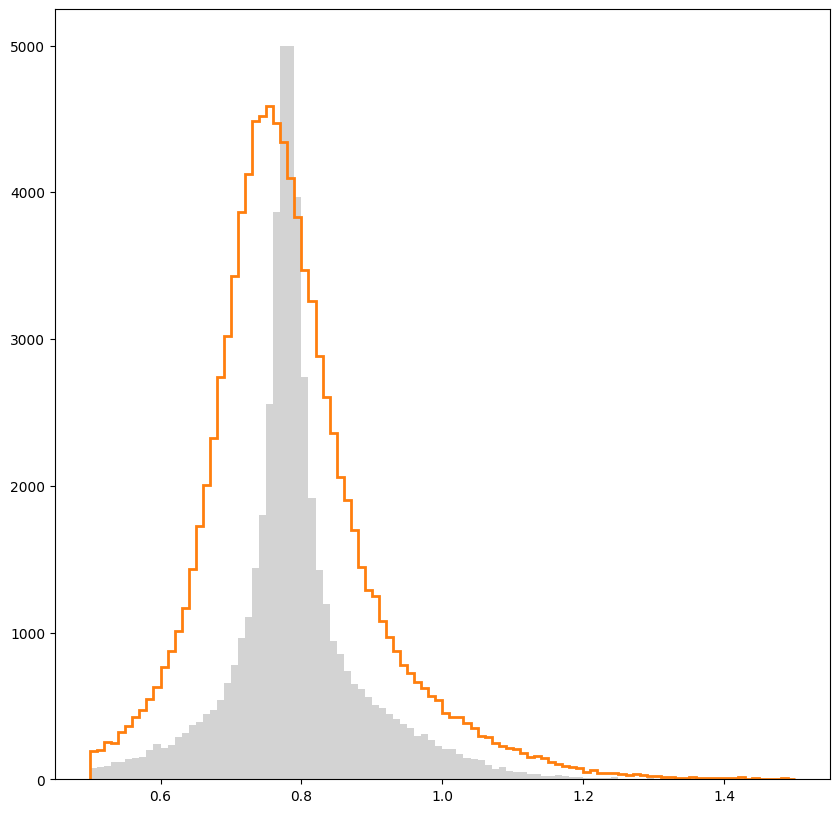

In [37]:
plt.figure(figsize=(10,10))
# h = plt.hist(visible_energy_true/energy_true.reshape(-1), bins=100, range=(0.5, 1.5), color='lightgrey', density=1)
# plt.hist(energy_sum/e_ins, bins=h[1], histtype='step', lw=2, color='tab:orange', density=1)
h = plt.hist(visible_energy_true/energy_true.reshape(-1), bins=100, range=(0.5, 1.5), color='lightgrey')
h2 = plt.hist(energy_sum/e_ins, bins=h[1], histtype='step', lw=2, color='tab:orange')
plt.show()

In [38]:
# separation power
ratios = (h[0] - h2[0])**2 / (h[0] + h2[0])

S2 = ratios[~np.isnan(ratios)].sum()/2
print(S2/200000)

0.06413050787796895


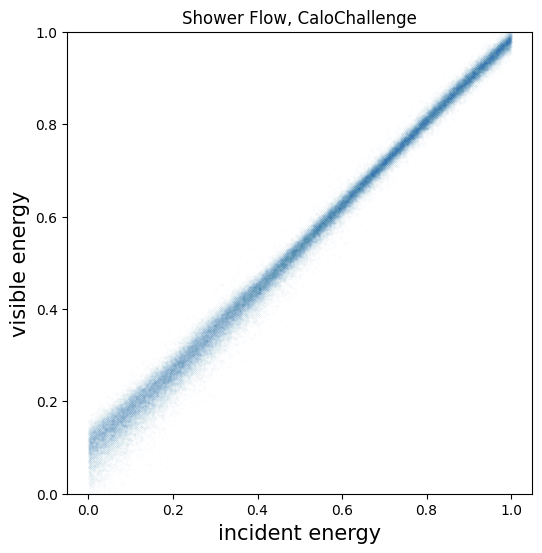

In [39]:
plt.figure(figsize=(6, 6))
plt.scatter(cond_E.cpu().numpy().reshape(-1), samples[:, 0], s=0.01, alpha=0.1)
plt.xlabel('incident energy', fontsize=15)
plt.ylabel('visible energy', fontsize=15)
# plt.xlim(-150,3900)
plt.ylim(0,1)
plt.title('Shower Flow, CaloChallenge')
plt.show()

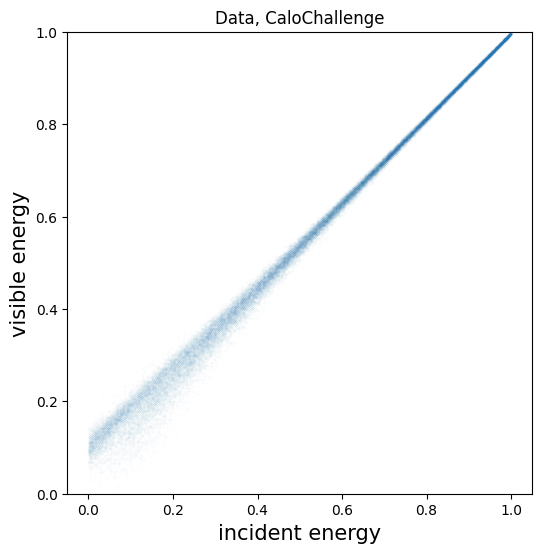

In [40]:
plt.figure(figsize=(6, 6))
plt.scatter(df.energy.values, df.visible_energy.values, s=0.01, alpha=0.1)
plt.xlabel('incident energy', fontsize=15)
plt.ylabel('visible energy', fontsize=15)
# plt.xlim(-150,3900)
plt.ylim(0,1)
plt.title('Data, CaloChallenge')
plt.show()

In [41]:
def invers_transform_energy(energy):
    energy_min, energy_max = 944.6402, 811494.44 # min max energy in the dataset
    return energy_min * (np.e ** (energy * np.log(energy_max / energy_min)))

def invers_transform_points(n_points):
    points_min, points_max = 201, 19206 # min max number of points in the dataset
    return points_min * (np.e ** (n_points * np.log(points_max / points_min)))

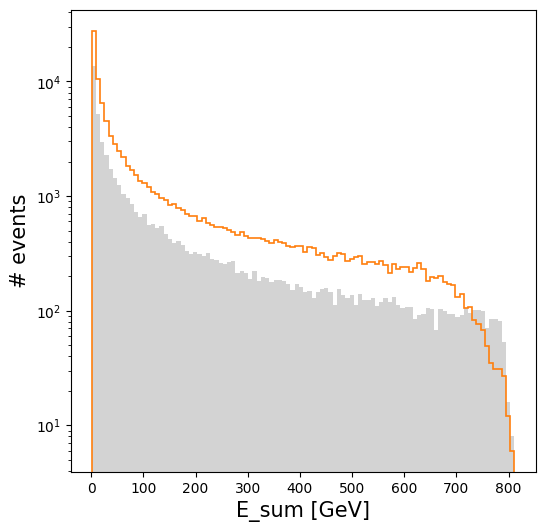

In [43]:
plt.figure(figsize=(6, 6))
h = plt.hist(invers_transform_energy(df.visible_energy.values)/1000, bins=100, color='lightgray')
plt.hist(invers_transform_energy(samples[:, 0])/1000, bins=h[1], histtype='step', color='tab:orange', lw=1.2)

plt.yscale('log')
plt.xlabel('E_sum [GeV]', fontsize=15)
plt.ylabel('# events', fontsize=15)
plt.show()

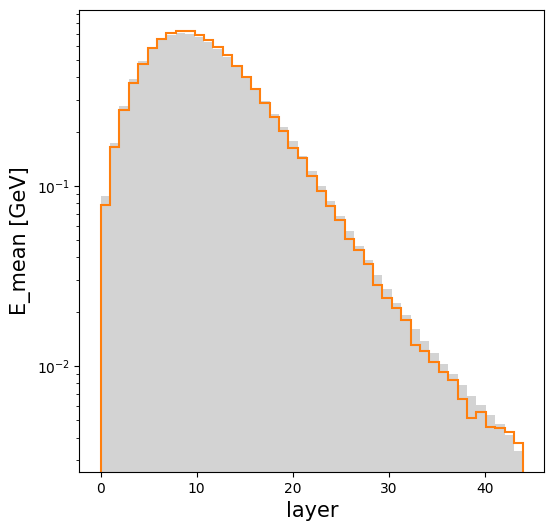

In [44]:
plt.figure(figsize=(6, 6))
h = plt.hist(np.arange(45), weights=e_per_layer.mean(axis=0), bins=45, color='lightgray')
plt.hist(np.arange(45), weights=samples[:, 2:47].mean(axis=0), bins=h[1], histtype='step', lw=1.5, color='tab:orange')
plt.yscale('log')
plt.xlabel('layer', fontsize=15)
plt.ylabel('E_mean [GeV]', fontsize=15)
plt.show()

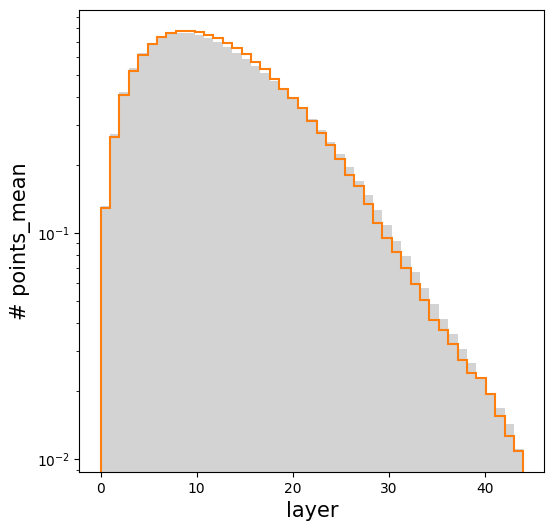

In [45]:
plt.figure(figsize=(6, 6))
h = plt.hist(np.arange(45), weights=clusters_per_layer.mean(axis=0), bins=45, color='lightgray')
plt.hist(np.arange(45), weights=samples[:, 47:].mean(axis=0), bins=h[1], histtype='step', lw=1.5, color='tab:orange')
plt.yscale('log')
plt.xlabel('layer', fontsize=15)
plt.ylabel('# points_mean', fontsize=15)
plt.show()

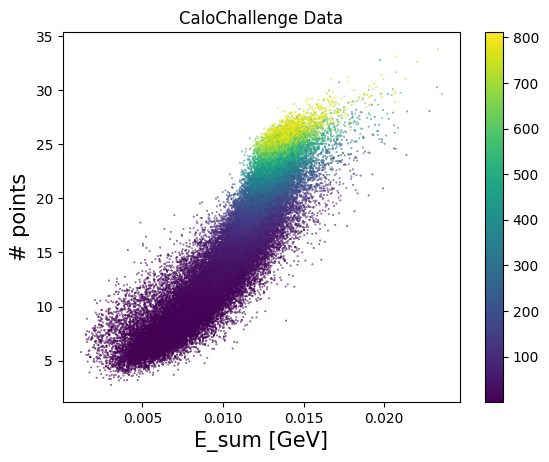

In [46]:
### plt.figure(figsize=(7, 6))
plt.scatter(e_per_layer.sum(axis=1)/1000, clusters_per_layer.sum(axis=1), s=0.1, c=invers_transform_energy(df.energy)/1000)
# plt.scatter(samples[:, 1:46].sum(axis=1)*40, samples[:, 46:].sum(axis=1)*600, color='tab:orange', s=0.1, alpha=0.1)
plt.xlabel('E_sum [GeV]', fontsize=15)
plt.ylabel('# points', fontsize=15)
plt.title('CaloChallenge Data')
plt.colorbar()
plt.show()

In [47]:
num_points_gen = invers_transform_points(samples[:, 1])
vis_energy_gen = invers_transform_energy(samples[:, 0])

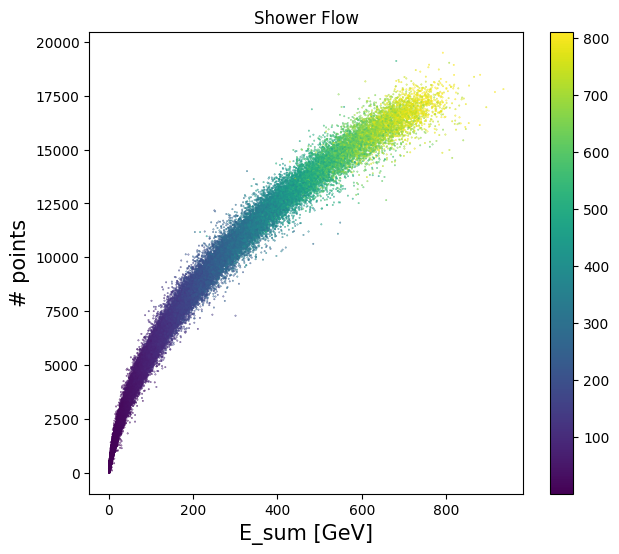

In [48]:
plt.figure(figsize=(7, 6))
plt.scatter(vis_energy_gen/1000, num_points_gen, c=invers_transform_energy(cond_E.cpu().numpy().reshape(-1))/1000, s=0.1)
plt.xlabel('E_sum [GeV]', fontsize=15)
plt.ylabel('# points', fontsize=15)
plt.title('Shower Flow')
plt.colorbar()
plt.show()